* Muhammad Khubaib Akram
* 23098929

   # GA applied to OneMax with Tournament Selection method

This notebook implements a simple GA in a fairly lowlevel way. In later examples we'll use more highlevel operators, but it is a very valuable exercise to ensure you understand what this code is actually doing. Make sure you understand the processes below before moving to the more high-level toolboxes!

Install DEAP. Note that if you are running this on your own computer you might not need to do this. In fact, it is better practice to install it so that it is always available, but when running on Colab, we do need this.

In [9]:
!pip install deap

Import the DEAP tools and useful libraries (random and matplotlib).

In [10]:
from deap import base
from deap import creator
from deap import tools

import random

import matplotlib.pyplot as plt

Set our Genetic Algorithm parameters

In [11]:
# Genetic Algorithm constants:
POPULATION_SIZE = 400
P_CROSSOVER = 0.7  # probability for crossover
P_MUTATION = 0.01   # probability for mutating an individual
MAX_GENERATIONS = 31

# Tournament size= 3
# Population 300 - Generation 43: Max Fitness = 100.0, Avg Fitness = 98.98666666666666 ||  Pop*MaxGenerations -12900
# Population 400 - Generation 31: Max Fitness = 100.0, Avg Fitness = 98.525 ||  Pop*MaxGenerations - 12400
# Population 1000 - Generation 26: Max Fitness = 100.0, Avg Fitness = 97.558 || Pop*MaxGenerations - 26000
# Population 50 - Generation 25: Max Fitness = 77.0, Avg Fitness = 75.32
# Population 70 - Generation 36: Max Fitness = 79.0, Avg Fitness = 79.0
# Population 70 - Generation 24: Max Fitness = 79.0, Avg Fitness = 78.6
# Population 60 - Generation 24: Max Fitness = 80.0, Avg Fitness = 79.71666666666667
# Population 58 - Generation 20: Max Fitness = 77.0, Avg Fitness = 76.13793103448276
# Population 100 - Generation 40: Max Fitness = 90.0, Avg Fitness = 88.14
# Population 100 - Generation 60: Max Fitness = 91.0, Avg Fitness = 90.01
# Population 100 - Generation 68: Max Fitness = 92.0, Avg Fitness = 91.01
# Population 120 - Generation 90: Max Fitness = 93.0, Avg Fitness = 93.0
# Population 170 - Generation 113: Max Fitness = 98.0, Avg Fitness = 97.98823529411764
# Population 170 - Generation 71: Max Fitness = 98.0, Avg Fitness = 96.98235294117647



Set any problem-specific constants here. In this case we need to know how long the string is.

In [12]:
ONE_MAX_LENGTH = 100  # length of bit string to be optimized

Set the random seed. This is important so that we can reproduce runs later on.

In [13]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

Create our toolbox. Note that we can pull in a bunch of predefined operators to tailor our Evolutionary Algorithm, which, of course, in this case is a GA. Notice that it is possible to create our **own** operators and functions to use, which is what we do with our **oneMaxFitness** function below.

In [14]:
toolbox = base.Toolbox()

# create an operator that randomly returns 0 or 1:
toolbox.register("zeroOrOne", random.randint, 0, 1)

# define a single objective, maximizing fitness strategy:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

# create the Individual class based on list:
creator.create("Individual", list, fitness=creator.FitnessMax)
#creator.create("Individual", array.array, typecode='b', fitness=creator.FitnessMax)

# create the individual operator to fill up an Individual instance:
toolbox.register("individualCreator", tools.initRepeat, creator.Individual, toolbox.zeroOrOne, ONE_MAX_LENGTH)

# create the population operator to generate a list of individuals:
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)


# fitness calculation:
# compute the number of '1's in the individual
def oneMaxFitness(individual):
    return sum(individual),  # return a tuple


toolbox.register("evaluate", oneMaxFitness)

# genetic operators:

# Tournament selection with tournament size of 3:
toolbox.register("select", tools.selTournament, tournsize=3)


# Single-point crossover:
toolbox.register("mate", tools.cxOnePoint)

# Flip-bit mutation:
# indpb: Independent probability for each attribute to be flipped
toolbox.register("mutate", tools.mutFlipBit, indpb=1.0/ONE_MAX_LENGTH)



/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Here is the main GA loop. We will iterate through it up to the MAX_GENERATIONS parameter and then print out our best individual.

In [15]:
# create initial population (generation 0):
population = toolbox.populationCreator(n=POPULATION_SIZE)
generationCounter = 0

# calculate fitness tuple for each individual in the population:
fitnessValues = list(map(toolbox.evaluate, population))
for individual, fitnessValue in zip(population, fitnessValues):
    individual.fitness.values = fitnessValue

# extract fitness values from all individuals in population:
fitnessValues = [individual.fitness.values[0] for individual in population]

# initialize statistics accumulators:
maxFitnessValues = []
meanFitnessValues = []

# main evolutionary loop:
# stop if max fitness value reached the known max value
# OR if number of generations exceeded the preset value:
while max(fitnessValues) < ONE_MAX_LENGTH and generationCounter < MAX_GENERATIONS:
    # update counter:
    generationCounter = generationCounter + 1

    # apply the selection operator, to select the next generation's individuals:
    offspring = toolbox.select(population, len(population))
    # clone the selected individuals:
    offspring = list(map(toolbox.clone, offspring))

    # apply the crossover operator to pairs of offspring:
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < P_CROSSOVER:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < P_MUTATION:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # calculate fitness for the individuals with no previous calculated fitness value:
    freshIndividuals = [ind for ind in offspring if not ind.fitness.valid]
    freshFitnessValues = list(map(toolbox.evaluate, freshIndividuals))
    for individual, fitnessValue in zip(freshIndividuals, freshFitnessValues):
        individual.fitness.values = fitnessValue

    # replace the current population with the offspring:
    population[:] = offspring

    # collect fitnessValues into a list, update statistics and print:
    fitnessValues = [ind.fitness.values[0] for ind in population]

    maxFitness = max(fitnessValues)
    meanFitness = sum(fitnessValues) / len(population)
    maxFitnessValues.append(maxFitness)
    meanFitnessValues.append(meanFitness)
    print("- Generation {}: Max Fitness = {}, Avg Fitness = {}".format(generationCounter, maxFitness, meanFitness))

    # find and print best individual:
    best_index = fitnessValues.index(max(fitnessValues))
    print("Best Individual = ", *population[best_index], "\n")

- Generation 1: Max Fitness = 66.0, Avg Fitness = 54.54
Best Individual =  1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 1 0 1 0 1 1 1 0 0 1 0 0 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1 0 1 0 0 1 0 1 1 0 0 1 1 1 1 0 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 1 

- Generation 2: Max Fitness = 66.0, Avg Fitness = 57.73
Best Individual =  1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 1 0 1 0 1 1 1 0 0 1 0 0 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1 0 1 0 0 1 0 1 1 0 0 1 1 1 1 0 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 1 

- Generation 3: Max Fitness = 72.0, Avg Fitness = 60.8025
Best Individual =  1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 1 0 1 0 1 1 1 0 0 1 0 0 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1 0 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 

- Generation 4: Max Fitness = 72.0, Avg Fitness = 63.4825
Best Individual =  1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 1 0 1 0 1 1 1 0 0 1 0 0 1 1 1 1 1 0 

Now that we're done, let's print out some statistics. Generally we record (at least) the max and average over time.

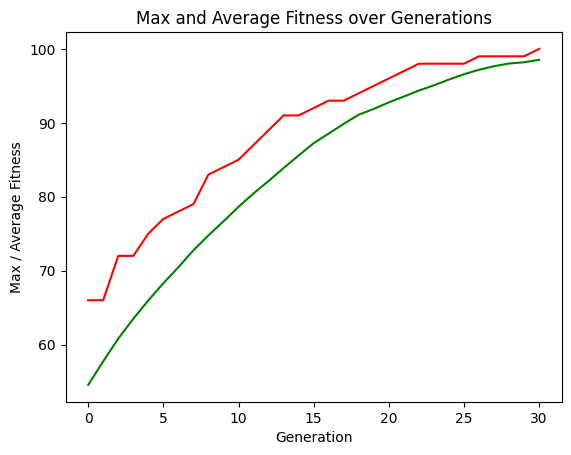

Population Size(400) and Max Generation (31)
Individuals processed(12400): the population size (400) multiplied by the number of generations (31) required.


In [16]:
# Genetic Algorithm is done - plot statistics:
#sns.set_style("whitegrid")
plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Max / Average Fitness')
plt.title('Max and Average Fitness over Generations')
plt.show()


print(f"Population Size({POPULATION_SIZE}) and Max Generation ({MAX_GENERATIONS})")
print(f"Individuals processed({POPULATION_SIZE*MAX_GENERATIONS}): the population size ({POPULATION_SIZE}) multiplied by the number of generations ({MAX_GENERATIONS}) required.")